<form action="index.ipynb">
    <input type="submit" value="Return to Index" style="background-color: green; color: white; width: 150px; height: 35px; float: right"/>
</form>

# Save Chain to Log File
Author(s): Paul Miles | Date Created: July 19, 2019

Many models are time consuming to evaluate.  As MCMC simulations required many model evaluations, it can be useful to periodically save the chain elements to a file.  This can be useful for a variety of reasons:

- Chain visualization while simulation continues to run.
- Chain is saved in the event that simulation ends prematurely.  

This is important when working on remote systems where you may have limited computation time.  This tutorial demonstrates the following:

- How to specify a log file directory
- Format to save log files in (binary or text)
- How to read in log files for analysis

# Run Simulation & Export to Log Files

Import required paths.

In [1]:
import numpy as np
from pymcmcstat.MCMC import MCMC
from datetime import datetime
import pymcmcstat
print(pymcmcstat.__version__)

1.9.0


Define a simple model and sum-of-squares function.

In [2]:
# define test model function
def test_modelfun(xdata, theta):
    m = theta[0]
    b = theta[1]
    nrow, ncol = xdata.shape
    y = np.zeros([nrow,1])
    y[:,0] = m*xdata.reshape(nrow,) + b
    return y

def test_ssfun(theta, data):
    xdata = data.xdata[0]
    ydata = data.ydata[0]
    # eval model
    ymodel = test_modelfun(xdata, theta)
    # calc sos
    ss = sum((ymodel[:, 0] - ydata[:, 0])**2)
    return ss

Initialize MCMC object:
- Add data
- Define model settings
- Define model parameters

In [3]:
# Initialize MCMC object
mcset = MCMC()
# Add data
nds = 100
x = np.linspace(2, 3, num=nds)
y = 2.*x + 3. + 0.1*np.random.standard_normal(x.shape)
mcset.data.add_data_set(x, y)
# update model settings
mcset.model_settings.define_model_settings(sos_function=test_ssfun)

mcset.parameters.add_model_parameter(
    name='m',
    theta0=2.,
    minimum=-10,
    maximum=np.inf,
    sample=True)
mcset.parameters.add_model_parameter(
    name='b',
    theta0=-5.,
    minimum=-10,
    maximum=100,
    sample=True)

## Define log file directory and turn on flags in simulations options
The following keyword arguments of the simulation options allow you to setup the log files.

- `savedir`: Directory in which to store log files.  If not specified, but log files turned on, then saves to directory with naming convention 'YYYYMMDD_hhmmss_chain_log'.
- `save_to_bin`: Save log files in binary format.  Uses `h5py` package for binary read/write.
- `save_to_txt`: Save log files in text format.  Uses `numpy` package for text read/write.

By default the feature is set to `False`.  You can save to either format or to both.  Regardless of what format is used to save the chain, a text log file will be included which appends a date/time stamp with corresponding chain indices.  This will be explained in more detail later.

To generate a set of results and save them to a specific directory, the following code can be executed:

In [5]:
import os
datestr = datetime.now().strftime('%Y%m%d_%H%M%S')
savedir = 'resources' + os.sep + str('{}_{}'.format(datestr, 'serial_chain'))
mcset.simulation_options.define_simulation_options(
    nsimu=int(5e4), updatesigma=1, method='dram',
    savedir=savedir, savesize=1000, save_to_json=True,
    verbosity=0, waitbar=False, save_to_txt=True, save_to_bin=True)

mcset.run_simulation()

# Process Simulation
At this point, the simulation is either running, or has completed running.  You will observe a folder in the working directory that matches the input argument for `savedir`.  In this case, we are going to reference a saved solution from the `resources` directory.

We observe that the folder `resources/20190517_073038_serial_chain` matches the pattern that was specified for `savedir`, and we display its contents

In [11]:
ls resources/20190517_073038_serial_chain/

20190517_073038_mcmc_simulation.json  s2chainfile.h5
binlogfile.txt                        s2chainfile.txt
chainfile.h5                          sschainfile.h5
chainfile.txt                         sschainfile.txt
covchainfile.h5                       txtlogfile.txt
covchainfile.txt


As expected, there are log files saved in both binary (h5) and text (txt) format.  Note, if you run this simulation on your machine, the results folder (`savedir`) will be different because of the date/time stamp.

## Processing the log files
We start by importing several modules from the [pymcmcstat](https://prmiles.wordpress.ncsu.edu/codes/python-packages/pymcmcstat/) package.  We note that this operation should be done from a separate script file, and possibly from a separate computer.  For example, if running a long simulation on a remote server, you can periodically copy the log files from the remote server and analyze the chains on your local machine.

In [20]:
from pymcmcstat.chain import ChainProcessing as CP
from pymcmcstat.chain.ChainStatistics import chainstats
from pymcmcstat import mcmcplot as mcp
import time

We initialize the plotting class and define the directory in which to find the log files.  If you want to look at results you generated, then chage the value of `savedir` accordingly.

In [21]:
# define directory where log files are saved
savedir = 'resources' + os.sep + '20190517_073038_serial_chain'
# For testing purposes we can repeatedly read in the data to see how binary versus text is processed.
ns = 10

Read in binary data files and print amount of time it takes to process.

In [22]:
start = time.time()
for ii in range(ns):
    results = CP.read_in_savedir_files(savedir, extension='h5')
end = time.time()
binary_time = end - start
print('Binary: {} sec\n'.format(binary_time/ns))

Binary: 0.05322208404541016 sec



In [23]:
start = time.time()
for ii in range(ns):
    results = CP.read_in_savedir_files(savedir, extension='txt')   
end = time.time()
text_time = end - start
print('Text: {} sec\n'.format(text_time/ns))

Text: 0.4920275926589966 sec



It is clearly seen that the binary files are more quickly processed.  In either case, the results extracted from the log files are identical, and we can proceed with the analysis.

## Analysis
We extract the following from the results dictionary:
- `chain`: Sampling chain for model parameters
- `s2chain`: Observation error chain
- `sschain`: Sum-of-squares error corresponding to each row of `chain`.

In [24]:
chain = results['chain']
s2chain = results['s2chain']
sschain = results['sschain']

We define the burn-in period for the chain as half the simulation run time.  Display statistics for burned-in portion of chain.

In [25]:
# define burnin
nsimu = chain.shape[0]
burnin = int(nsimu/2)
# display chain statistics
stats = chainstats(chain[burnin:,:], returnstats=True)



------------------------------
name      :       mean        std     MC_err        tau     geweke
$p_{0}$   :     2.1135     0.0391     0.0017    38.1465     0.9989
$p_{1}$   :     2.7027     0.0984     0.0044    37.5644     0.9975
------------------------------
Acceptance rate information
Chain provided:
Net    : 20.32% -> 5079/25000
------------------------------


## Plot Chain
- Chain panel
- pairwise correlation

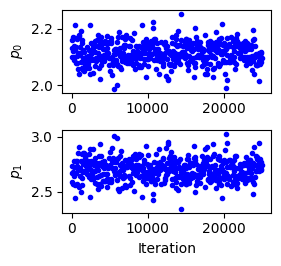

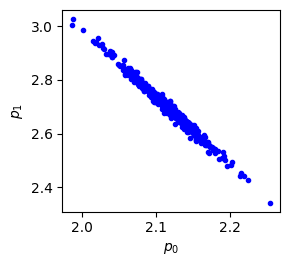

In [26]:
settings=dict(fig=dict(figsize=(3, 3)))
mcp.plot_chain_panel(chain[burnin:, :], settings=settings)
mcp.plot_pairwise_correlation_panel(chain[burnin:, :], settings=settings);

## Print log files
Log files display a date/time stamp associated with when chain segments were appended to the correponding log file.

| Date    | Time | Start | End |
|--------------|---------|---------|---------|
|2019-05-17| 07:30:40|	0|	999|
|2019-05-17| 07:30:40|	1000|	1999|
|2019-05-17| 07:30:41|	2000|	2999|
|2019-05-17| 07:30:41|	3000|	3999|
|2019-05-17| 07:30:41|	4000|	4999|
|2019-05-17| 07:30:41|	5000|	5999|



In [27]:
CP.print_log_files(savedir)

--------------------------
Display log file: resources/20190517_073038_serial_chain/binlogfile.txt
2019-05-17 07:30:40	0	999
2019-05-17 07:30:40	1000	1999
2019-05-17 07:30:41	2000	2999
2019-05-17 07:30:41	3000	3999
2019-05-17 07:30:41	4000	4999
2019-05-17 07:30:41	5000	5999
2019-05-17 07:30:42	6000	6999
2019-05-17 07:30:42	7000	7999
2019-05-17 07:30:42	8000	8999
2019-05-17 07:30:43	9000	9999
2019-05-17 07:30:43	10000	10999
2019-05-17 07:30:43	11000	11999
2019-05-17 07:30:43	12000	12999
2019-05-17 07:30:44	13000	13999
2019-05-17 07:30:44	14000	14999
2019-05-17 07:30:44	15000	15999
2019-05-17 07:30:45	16000	16999
2019-05-17 07:30:45	17000	17999
2019-05-17 07:30:45	18000	18999
2019-05-17 07:30:45	19000	19999
2019-05-17 07:30:46	20000	20999
2019-05-17 07:30:46	21000	21999
2019-05-17 07:30:46	22000	22999
2019-05-17 07:30:47	23000	23999
2019-05-17 07:30:47	24000	24999
2019-05-17 07:30:47	25000	25999
2019-05-17 07:30:48	26000	26999
2019-05-17 07:30:48	27000	27999
2019-05-17 07:30:48	28000	289